<a href="https://colab.research.google.com/github/raphaelmendes18/kaggle-competitions/blob/master/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Titanic Disaster Prediction
Author: Raphael L Mendes

* Accuracy: 0.77990 (November 4th)
* Accuracy: 0.79904 (November 6th)
* Accuracy: 0.80382 (November 7th) Top 9%

To do:

1.   Creative Feature Engineering;
2.   Grid Search;
3.   Ensemble Models;



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
### read files

train = pd.read_csv('/content/drive/My Drive/kaggle/titanic/train.csv')
test = pd.read_csv('/content/drive/My Drive/kaggle/titanic/test.csv')

train_ids = train['PassengerId']
test_ids = test['PassengerId']

### capture target variable
y_train = train['Survived']




In [4]:
test_ids

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

### Let's look at the target variable


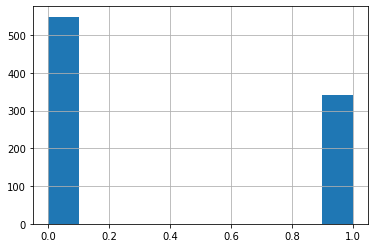

In [5]:
y_train.hist()

### Attempt #1

In [0]:
### concatenate train, test
all_data = pd.concat([train.drop(columns={'Survived','PassengerId'}), test.drop(columns='PassengerId')])

### Pclass Should be treated as categorical too

all_data['Pclass'] = all_data['Pclass'].astype(str) 

### Creating new feature, family_size

all_data['FamilySize'] = all_data['Parch'] + all_data['SibSp'] + 1
all_data.loc[all_data['FamilySize']>1,'IsAlone'] = 0
all_data.loc[all_data['FamilySize']==1,'IsAlone'] = 1
all_data['IsAlone'] = all_data['IsAlone'].astype(str)
### Feature Engineering from Name

def parse_name(name):

    if name.find('Mr.') != -1 or name.find('Don.') != -1 or name.find('Dr.') != -1 :
        return 'Mr.'
    elif name.find('Mrs.') != -1  or name.find('Mlle.') != -1 :
        return 'Mrs.'
    elif name.find('Miss.') != -1 or name.find('Mme.') != -1 or name.find('Ms.') != -1:
        return 'Miss.'
    elif name.find('Master.') != -1:
        return 'Master.'
    elif name.find('Dona.') != -1:
        return 'Mrs.'
    elif name.find('Rev.') != -1:
        return 'Rev.'
    elif name.find('Major.') != -1 or name.find('Capt.') != -1 or name.find('Col.') != -1:
        return 'Military.'
    elif name.find('Jonkheer.') != -1 or name.find('Lady.') != -1 or name.find('Countess.') != -1 or name.find('Sir.') != -1:
        return 'Noble.'
    else:
        return name

all_data['Title'] = all_data['Name'].apply(lambda x: parse_name(x))

all_data = all_data.drop(columns='Name')

### Check for nan
### Columns Empty -> Cabin (0.77) and Embarked (0.001528)

### Embarked has only a few nan, will use mode
all_data['Embarked'] = all_data['Embarked'].fillna((all_data['Embarked'].mode()[0]))

### Cabin has too many nan, will drop this columns
### Drop Ticket too
all_data = all_data.drop(columns={'Cabin','Ticket'})

### Check for nan in numerical
### Fare and Age have empty values
all_data['Fare'] = all_data.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.median()))
all_data['Age'] = all_data.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))

all_data.apply(lambda x: sum(x.isna())/len(x))
categorical_data = all_data.select_dtypes(include='object')
numeric_data = all_data.select_dtypes(exclude='object')
numerical_cols = numeric_data.columns
from sklearn.preprocessing import LabelEncoder
cols = categorical_data.columns
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

all_data[['Pclass','Sex','Embarked','Title','IsAlone']] = all_data[['Pclass','Sex','Embarked','Title','IsAlone']].astype(str)

### Test for Skewness
from scipy.stats import skew
from scipy.special import boxcox1p

skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

all_data_dummies = pd.get_dummies(all_data)

X_train_final = all_data_dummies[:len(train_ids)].values
X_test_final = all_data_dummies[len(train_ids):].values

# colormap = plt.cm.RdBu
# plt.figure(figsize=(15,15))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(pd.concat([all_data[:len(train_ids)],train['Survived']]).astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True, cmap=colormap, linecolor='white', annot=True)

# plt.show()
# g = sns.pairplot(pd.concat([all_data[:len(train_ids)],train['Survived']]), hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
# g.set(xticklabels=[])

# plt.show()

### Attempt 2

Fare


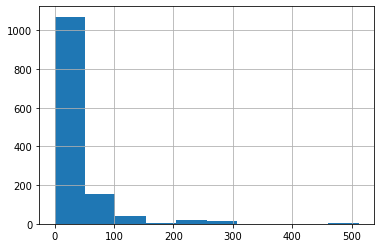

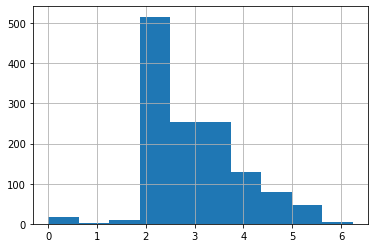

SibSp


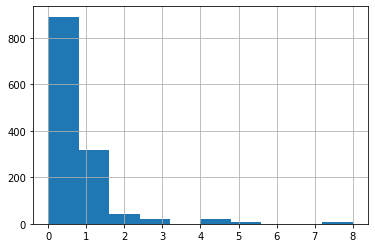

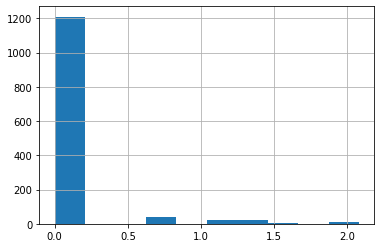

Parch


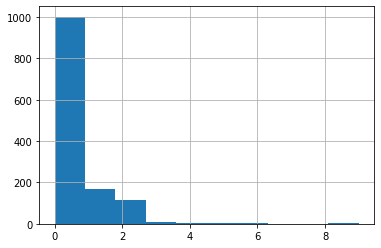

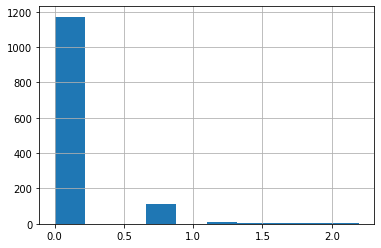

FamilySize


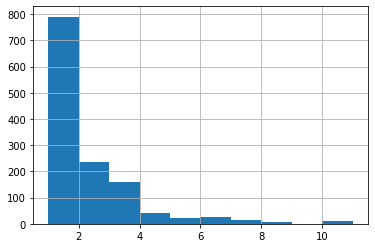

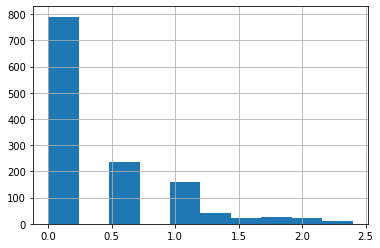

Age


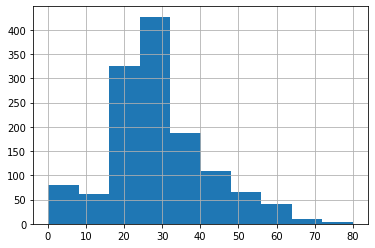

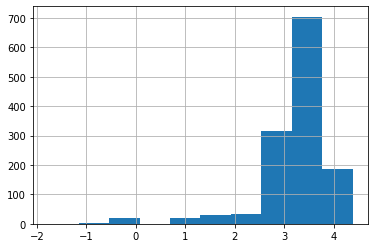

In [21]:
### concatenate train, test
all_data = pd.concat([train.drop(columns={'Survived','PassengerId'}), test.drop(columns='PassengerId')])

### Pclass Should be treated as categorical too

all_data['Pclass'] = all_data['Pclass'].astype(str) 

### Creating new feature, family_size

all_data['FamilySize'] = all_data['Parch'] + all_data['SibSp'] + 1
all_data.loc[all_data['FamilySize']>1,'IsAlone'] = 0
all_data.loc[all_data['FamilySize']==1,'IsAlone'] = 1
all_data['IsAlone'] = all_data['IsAlone'].astype(str)
### Feature Engineering from Name

def parse_name(name):

    if name.find('Mr.') != -1 or name.find('Don.') != -1 or name.find('Dr.') != -1 :
        return 'Mr.'
    elif name.find('Mrs.') != -1  or name.find('Mlle.') != -1 :
        return 'Mrs.'
    elif name.find('Miss.') != -1 or name.find('Mme.') != -1 or name.find('Ms.') != -1:
        return 'Miss.'
    elif name.find('Master.') != -1:
        return 'Master.'
    elif name.find('Dona.') != -1:
        return 'Mrs.'
    elif name.find('Rev.') != -1:
        return 'Rare.'
    elif name.find('Major.') != -1 or name.find('Capt.') != -1 or name.find('Col.') != -1:
        return 'Rare.'
    elif name.find('Jonkheer.') != -1 or name.find('Lady.') != -1 or name.find('Countess.') != -1 or name.find('Sir.') != -1:
        return 'Rare.'
    else:
        return name

all_data['Title'] = all_data['Name'].apply(lambda x: parse_name(x))

all_data = all_data.drop(columns='Name')

### Check for nan
### Columns Empty -> Cabin (0.77) and Embarked (0.001528)

### Embarked has only a few nan, will use mode
all_data['Embarked'] = all_data['Embarked'].fillna((all_data['Embarked'].mode()[0]))

### Cabin has too many nan, will drop this columns
### Drop Ticket too

# Replace the Cabin number by the type of cabin 'X' if not
all_data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in all_data['Cabin'] ])

## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(all_data.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
all_data["Ticket"] = Ticket
all_data["Ticket"].head()

### Check for nan in numerical
### Fare and Age have empty values
all_data['Fare'] = all_data.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.median()))
all_data['Age'] = all_data.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))

all_data.apply(lambda x: sum(x.isna())/len(x))
categorical_data = all_data.select_dtypes(include='object')
numeric_data = all_data.select_dtypes(exclude='object')
numerical_cols = numeric_data.columns
from sklearn.preprocessing import LabelEncoder
cols = categorical_data.columns
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

all_data[['Pclass','Sex','Embarked','Title','IsAlone']] = all_data[['Pclass','Sex','Embarked','Title','IsAlone']].astype(str)

### Test for Skewness
from scipy.stats import skew
from scipy.special import boxcox1p

skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    print(feat)
    all_data[feat].hist()
    plt.show()
    # all_data[feat]=boxcox1p(all_data[feat], lam)
    all_data[feat] = all_data[feat].map(lambda i: np.log(i) if i > 0 else 0)
    all_data[feat].hist()
    plt.show()

all_data_dummies = pd.get_dummies(all_data)

X_train_final = all_data_dummies[:len(train_ids)].values
X_test_final = all_data_dummies[len(train_ids):].values


### Validation

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost
import numpy as np
X = X_train_final

y = train['Survived'].values
verbose = False
kf = KFold(n_splits=10,shuffle=True, random_state=2)
kf.get_n_splits(X)
fold = 0
results = []

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

rf_weight = 0
xgb_weight = 0
lgb_weight = 0

rf_cv = []
lgb_cv = []
xgb_cv = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rfc = RandomForestClassifier(n_estimators=500)
    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_test, label=y_test)
    watchlist = [d_valid]

    clf = lgb.train(params, d_train, 500, watchlist, verbose_eval=0)
    lgb_y_pred_log_loss = clf.predict(X_test)

    lgb_y_pred = np.zeros(len(lgb_y_pred_log_loss))

    for i in range(len(lgb_y_pred)):
        if lgb_y_pred_log_loss[i]>=.5:       # setting threshold to .5
            lgb_y_pred[i]=1
        else:  
            lgb_y_pred[i]=0


    xgbclf = xgboost.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=500)
    xgbclf.fit(X_train,y_train)
    xgb_y_pred = xgbclf.predict(X_test)

    fold+=1

    if verbose == True:
        print('Fold: {}.'.format(fold))
        print('Random Forest')
        print('Accuracy Score: {}'.format(accuracy_score(y_pred,y_test)))
        print('F1-Score: {}'.format(f1_score(y_pred,y_test)))
        print('ROC_Curve: {}'.format(roc_auc_score(y_pred,y_test)))
        print('------------------------------------')
        print('LGBM')
        print('Accuracy Score: {}'.format(accuracy_score(lgb_y_pred,y_test)))
        print('F1-Score: {}'.format(f1_score(lgb_y_pred,y_test)))
        print('ROC_Curve: {}'.format(roc_auc_score(lgb_y_pred,y_test)))
        print('------------------------------------')
        print('XGB')
        print('Accuracy Score: {}'.format(accuracy_score(xgb_y_pred,y_test)))
        print('F1-Score: {}'.format(f1_score(xgb_y_pred,y_test)))
        print('ROC_Curve: {}'.format(roc_auc_score(xgb_y_pred,y_test)))
        print('------------------------------------')

    acc_rf = accuracy_score(y_pred,y_test)
    acc_lgb = accuracy_score(lgb_y_pred,y_test)
    acc_xgb = accuracy_score(xgb_y_pred,y_test)

    if acc_rf > acc_lgb:
        if acc_rf > acc_xgb:
            rf_weight += 1
        else:
            xgb_weight += 1
    else:
        if acc_lgb > acc_xgb:
            lgb_weight += 1
        else:
            xgb_weight += 1

    rf_cv.append(acc_rf)
    lgb_cv.append(acc_lgb)
    xgb_cv.append(acc_xgb)
rf_w = (rf_weight/(rf_weight + xgb_weight + lgb_weight))
xgb_w = (xgb_weight/(rf_weight + xgb_weight + lgb_weight))
lgb_w = (lgb_weight/(rf_weight + xgb_weight + lgb_weight))

print('Random Forest: mean ({}) - std ({})'.format(np.mean(rf_cv),np.std(rf_cv)))
print('LGB: mean ({}) - std ({})'.format(np.mean(lgb_cv),np.std(lgb_cv)))
print('XGB: mean ({}) - std ({})'.format(np.mean(xgb_cv),np.std(xgb_cv)))


Random Forest: mean (0.8181772784019975) - std (0.0336515551301254)
LGB: mean (0.8238451935081148) - std (0.03830675284974366)
XGB: mean (0.8215605493133582) - std (0.03266486652826511)


In [0]:
print(rf_w)
print(xgb_w)
print(lgb_w)

0.2
0.4
0.4


In [0]:
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X,y)
rfc_y_pred = rfc.predict(X_test_final)

clf = lgb.train(params, d_train, 500, watchlist, verbose_eval=0)
lgb_y_pred_log_loss = clf.predict(X_test_final)

lgb_y_pred = np.zeros(len(lgb_y_pred_log_loss))

for i in range(len(lgb_y_pred)):
    if lgb_y_pred_log_loss[i]>=.5:       # setting threshold to .5
        lgb_y_pred[i]=1
    else:  
        lgb_y_pred[i]=0


xgbclf = xgboost.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=500)
xgbclf.fit(X,y)
xgb_y_pred = xgbclf.predict(X_test_final)

In [0]:
avg_y_pred = (rf_w*rfc_y_pred + lgb_w*lgb_y_pred + xgb_w*xgb_y_pred)
output = []
for y_value in avg_y_pred:
    if y_value > 0.5:
        output.append(1)
    else:
        output.append(0)

averaged_df = pd.DataFrame(output,columns=['Survived'])
averaged_df.index += 892
averaged_df.reset_index(inplace=True)
averaged_df.rename(columns={'index':'PassengerId'},inplace=True)
averaged_df.to_csv('/content/drive/My Drive/kaggle/titanic/averaged_output_v3.csv',index=False)

In [0]:
xgb_df = pd.DataFrame(xgb_y_pred,columns=['Survived'])
xgb_df.index += 892
xgb_df.reset_index(inplace=True)
xgb_df.rename(columns={'index':'PassengerId'},inplace=True)
xgb_df.to_csv('/content/drive/My Drive/kaggle/titanic/xgb_output_v3.csv',index=False)

In [0]:
lgb_df = pd.DataFrame(lgb_y_pred,columns=['Survived'])
lgb_df['Survived'] = lgb_df['Survived'].astype(int)
lgb_df.index += 892
lgb_df.reset_index(inplace=True)
lgb_df.rename(columns={'index':'PassengerId'},inplace=True)
lgb_df.to_csv('/content/drive/My Drive/kaggle/titanic/lgb_output_v3.csv',index=False)

In [0]:
xgb_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### Ensembling Models

In [0]:
from sklearn.model_selection import KFold
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

lgb_params = {
    'learning_rate' : 0.01,
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'sub_feature' : 0.5,
    'num_leaves' : 10,
    'min_data' : 50,
    'max_depth' : 10,
    'n_estimators': 500
}

# d_train = lgb.Dataset(X_train, label=y_train)
# d_valid = lgb.Dataset(X_test, label=y_test)
# watchlist = [d_valid]

# clf = lgb.train(params, d_train, 500, watchlist, verbose_eval=0)
# lgb_y_pred_log_loss = clf.predict(X_test)

# lgb_y_pred = np.zeros(len(lgb_y_pred_log_loss))


# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=2)


# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i = 0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i += 1
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)



In [35]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train_final, train['Survived'].values, X_test_final) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, X_train_final, train['Survived'].values, X_test_final) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train_final, train['Survived'].values, X_test_final) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, X_train_final, train['Survived'].values, X_test_final) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, X_train_final, train['Survived'].values, X_test_final) # Support Vector Classifier

print("Training is complete")

# lgb = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [0]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
      'SVM': svc_oof_train.ravel()
    })

base_predictions_test = pd.DataFrame( {'RandomForest': rf_oof_test.ravel(),
     'ExtraTrees': et_oof_test.ravel(),
     'AdaBoost': ada_oof_test.ravel(),
      'GradientBoost': gb_oof_test.ravel(),
      'SVM': svc_oof_test.ravel()
    })


### 2nd Level Classifier

In [0]:
import lightgbm as lgb

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

d_train = lgb.Dataset(base_predictions_train, label=train['Survived'].values)
# d_test = lgb.Dataset(base_predictions_test)
# watchlist = [d_valid]

clf = lgb.train(params, d_train, 500, verbose_eval=0)
lgb_y_pred_log_loss = clf.predict(base_predictions_test)

lgb_y_pred = np.zeros(len(lgb_y_pred_log_loss))

for i in range(len(lgb_y_pred)):
    if lgb_y_pred_log_loss[i]>=.5:       # setting threshold to .5
        lgb_y_pred[i]=1
    else:  
        lgb_y_pred[i]=0



In [0]:
lgb_df = pd.DataFrame(lgb_y_pred,columns=['Survived'])
lgb_df['Survived'] = lgb_df['Survived'].astype(int)
lgb_df.index += 892
lgb_df.reset_index(inplace=True)
lgb_df.rename(columns={'index':'PassengerId'},inplace=True)
lgb_df.to_csv('/content/drive/My Drive/kaggle/titanic/stacked_2_level_lgb_output_v1.csv',index=False)

{'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 10,
 'metric': 'binary_logloss',
 'min_data': 50,
 'num_leaves': 10,
 'objective': 'binary',
 'sub_feature': 0.5}